In [274]:
config_name = 'outputs/model_25_1config'
#config_name = 'outputs/new_model_1config'
#config_name = 'outputs/model0_longerconfig'
time_horizon = 1000
wanted_shot = '180636'

In [275]:
%load_ext autoreload
%autoreload 2
import torch
import h5py as h5
import matplotlib.pyplot as plt
import os
import configparser
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import sys
sys.path.append(os.path.expanduser("~/TMPredictor/survival_tm/auton-survival"))
from auton_survival.preprocessing import Scaler
import optuna
from sklearn.model_selection import ParameterGrid
#sys.path.append('/projects/EKOLEMEN/survival_tm/train_models/auton-survival')
sys.path.append(os.path.expanduser("~/TMPredictor/survival_tm/auton-survival"))
from sklearn.model_selection import ParameterGrid
from auton_survival.estimators import SurvivalModel
from auton_survival.metrics import survival_regression_metric
from auton_survival.models.dsm import DeepSurvivalMachines
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc
from get_survival_from_shot import get_rt_survival_from_shot, get_cakenn_survival_from_shot
import metrics_helpers
import plotting_helpers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


LOAD MODEL AND ITS DATABASE

/home/hf8585/TMPredictor/survival_tm/auton-survival/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


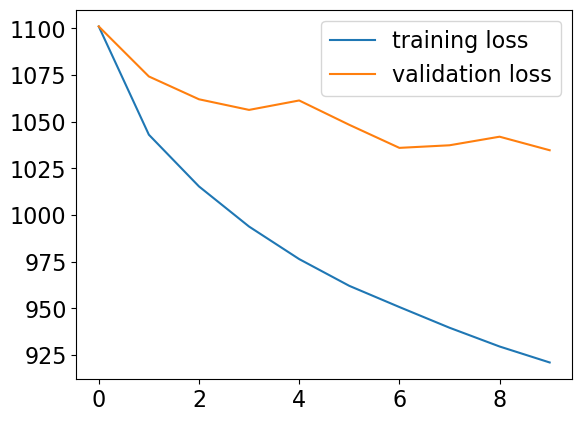

In [276]:
# READ CONFIG
config = configparser.ConfigParser()
config.read(config_name)
database_x_name = config['model']['database_x_name']
database_e_name = config['model']['database_e_name']
database_t_name = config['model']['database_t_name']

# if database_shots_list_name exists
if 'database_shots_list_name' in config['model']:
    database_shots_list_name = config['model']['database_shots_list_name']
if 'database_real_times_name' in config['model']:
    database_real_times_name = config['model']['database_real_times_name']
output_filename_base = config['model']['output_filename_base']
seed = eval(config['training']['seed'])[0]
# LOAD DATABASE
with open(f'/projects/EKOLEMEN/survival_tm_2/data/{database_x_name}.pkl', 'rb') as f:
    x = pickle.load(f)
with open(f'/projects/EKOLEMEN/survival_tm_2/data/{database_e_name}.pkl', 'rb') as f:
    e = pickle.load(f)
with open(f'/projects/EKOLEMEN/survival_tm_2/data/{database_t_name}.pkl', 'rb') as f:
    t = pickle.load(f)
if 'database_shots_list_name' in config['model']:
    with open(f'/projects/EKOLEMEN/survival_tm_2/data/{database_shots_list_name}.pkl', 'rb') as f:
        shots_list = pickle.load(f)
if 'database_real_times_name' in config['model']:
    with open(f'/projects/EKOLEMEN/survival_tm_2/data/{database_real_times_name}.pkl', 'rb') as f:
        real_times = pickle.load(f)
x_train_df = np.array(x)
# LOAD MODEL
with open(f'models/{output_filename_base}.pkl', 'rb') as f:
    loaded_models = pickle.load(f)
    model = loaded_models[2][0]

plt.plot(loaded_models[0][1], label='training loss')
plt.plot(np.array(loaded_models[0][2])*loaded_models[0][1][0]/loaded_models[0][2][0], label='validation loss')
plt.legend()
survival_output = model.predict_survival(pd.DataFrame(x), [time_horizon])

In [277]:
# train, val and test datasets
x = np.array(x)
unique_shots = np.unique(shots_list)
# find the index of the first occurrence of each unique shot
shots_indices = [np.where(shots_list == shot)[0][0] for shot in unique_shots]
shots_to_index_dict = {}
for i, shot in enumerate(unique_shots):
    shots_to_index_dict[shot] = np.arange(shots_indices[i], shots_indices[i+1]) if i < len(shots_indices) - 1 else np.arange(shots_indices[i], len(shots_list))

# select random 80% of shots for training, 10% for validation, and 10% for testing
rng = np.random.default_rng(seed)  # Set a random seed for reproducibility
shots_train = rng.choice(unique_shots, size=int(len(unique_shots)*0.8), replace=False)
shots_valid = rng.choice(np.setdiff1d(unique_shots, shots_train), size=int(len(unique_shots)*0.1), replace=False)
shots_test = np.setdiff1d(unique_shots, np.concatenate((shots_train, shots_valid)))

indices_train = np.concatenate([shots_to_index_dict[shot] for shot in shots_train])
indices_valid = np.concatenate([shots_to_index_dict[shot] for shot in shots_valid])
indices_test = np.concatenate([shots_to_index_dict[shot] for shot in shots_test])

x_train_df = pd.DataFrame(x[indices_train]).reset_index(drop=True)
x_valid_df = pd.DataFrame(x[indices_valid]).reset_index(drop=True)
x_test_df = pd.DataFrame(x[indices_test]).reset_index(drop=True)
shots_list_train = shots_list[indices_train]
shots_list_valid = shots_list[indices_valid]
shots_list_test = shots_list[indices_test]
e_train = e[indices_train]
e_valid = e[indices_valid]
e_test = e[indices_test]
t_train = t[indices_train]
t_valid = t[indices_valid]
t_test = t[indices_test]
outcomes_train_df = pd.DataFrame({'time': t_train, 'event': e_train})
outcomes_valid_df = pd.DataFrame({'time': t_valid, 'event': e_valid})

high qmin experiment shots

RUN MODEL

In [47]:
print(list(np.unique(shots_list)))

['150518', '150519', '150520', '150521', '150523', '150524', '150525', '150528', '150531', '150533', '150536', '150537', '150554', '150601', '150602', '150603', '150604', '150605', '150606', '150607', '150610', '150613', '150614', '150615', '150616', '150617', '150618', '150619', '150620', '150621', '150622', '150624', '154293', '154294', '154295', '154296', '154297', '154298', '154302', '154303', '154363', '154364', '154365', '154366', '154368', '154369', '154370', '154371', '154372', '154373', '154374', '154375', '154376', '154377', '154378', '154379', '154380', '154381', '154382', '154385', '154391', '154405', '154406', '154407', '154408', '154409', '154410', '154413', '154414', '154415', '154417', '154419', '154421', '154428', '154429', '154430', '154431', '154432', '154433', '154434', '154435', '154436', '154437', '154438', '154442', '154521', '154522', '154523', '154524', '154525', '154528', '154530', '154532', '154534', '154716', '154717', '154718', '154719', '154720', '154721',

1064272 1064401


Text(0.5, 1.0, 'Shot 180637')

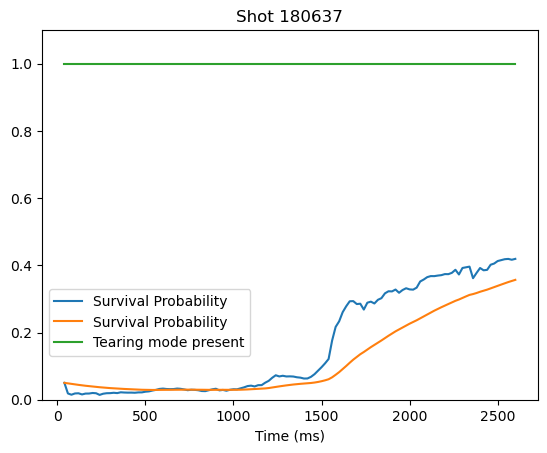

In [106]:
wanted_shot = '180637'
#wanted_shot = np.unique(shots_list)[1800]
#survival_output = model.predict_survival(pd.DataFrame(x), [time_horizon])

# FIND START AND END OF WANTED SHOT IN DATABASE
start_index = np.where(shots_list == wanted_shot)[0][0]
end_index = len(shots_list) - 1 - np.where(shots_list[::-1] == wanted_shot)[0][0]

print(start_index, end_index)
x_shot = x[start_index:end_index]
t_shot = t[start_index:end_index][::-1]
survival_output_shot = 1-survival_output[start_index:end_index]
plt.ylim(0, 1.1)
plt.plot(t_shot, survival_output_shot, label='Survival Probability')
plt.plot(t_shot, metrics_helpers.LP_filter(survival_output_shot, alpha=0.95), label='Survival Probability')
plt.plot(t_shot, e[start_index:end_index], label='Tearing mode present')
#plt.plot(t_shot, 1-t_shot/t_shot.max(), label='Normalized time to tearing mode')
plt.xlabel('Time (ms)')
plt.legend(loc='lower left', bbox_to_anchor=(0, 0.1))
plt.title(f'Shot {wanted_shot}')
#plt.xlim(1500, 5000)

In [5]:
survival_output = model.predict_survival(pd.DataFrame(x_pt), [time_horizon])
wanted_shot = '199597'
# FIND START AND END OF WANTED SHOT IN DATABASE
start_index = np.where(shots_list_pt == wanted_shot)[0][0]
end_index = len(shots_list_pt) - 1 - np.where(shots_list_pt[::-1] == wanted_shot)[0][0]

print(start_index, end_index)
x_shot = x_pt[start_index:end_index]
t_shot = times_list_pt[start_index:end_index]
survival_output_shot = 1-survival_output[start_index:end_index]
#plt.ylim(0, 0.5)
plt.plot(t_shot, survival_output_shot, label='Survival Probability')
plt.plot(t_shot, metrics_helpers.LP_filter(survival_output_shot, alpha=0.64), label='Survival Probability')
#plt.plot(t_shot, e[start_index:end_index], label='Tearing mode present')
#plt.plot(t_shot, 1-t_shot/t_shot.max(), label='Normalized time to tearing mode')
plt.xlabel('Time (ms)')
#plt.legend(loc='lower left', bbox_to_anchor=(0, 0.1))
plt.title(f'Shot {wanted_shot}')

NameError: name 'x_pt' is not defined

PLOT SPECIFIC SHOT VALUES

RUN INFERENCE ON NEW SHOT WITH DATA FROM DATA-FETCHING

In [ ]:
# CAKENN example
cakenn_times, cakenn_survival_output, cakenn_x = get_cakenn_survival_from_shot('199598', '199596199610_data_outputs', 'recent_data_scalars199596_199610', 'cake_normalizations_dict', 'cakenn_norm_fixed', 1000)

# RT example
rt_times, rt_survival_output, rt_x = get_rt_survival_from_shot('180637', 'recent_data180634_180640', 'rt_normalizations_dict', 'rt_fixed_rot_large', 1000)

GENERAL MODEL ANALYSIS

Text(0.5, 1.0, 'model_25_1 AUC = 0.8890028256312096')

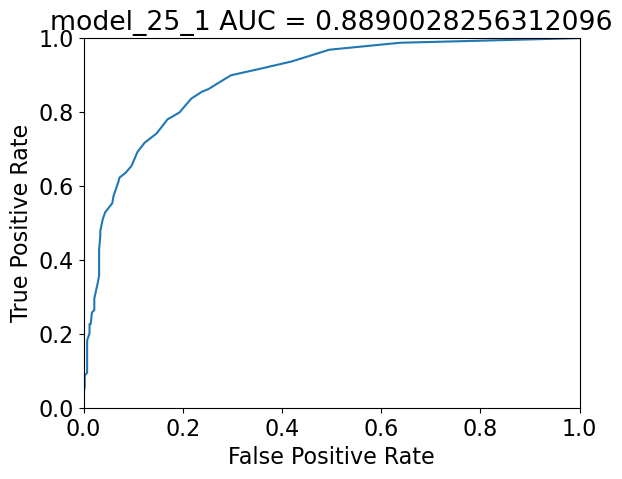

In [280]:
survival_output_valid = survival_output[indices_valid]
thresholds = np.linspace(0, 1, 100)
fprs = []
fnrs = []
warning_times_list = []
jumps_list = []
classification_list = []
for threshold in thresholds:
    classification, warning_times, jumps, shots, fpr, fnr = metrics_helpers.classify_database(metrics_helpers.LP_filter(1-survival_output_valid, alpha=0.95), e_valid, t_valid, shots_list_valid, threshold)
    fprs.append(fpr)
    fnrs.append(fnr)
    warning_times_list.append(warning_times)
    jumps_list.append(jumps)
    classification_list.append(classification)

fprs = np.array(fprs)
fnrs = np.array(fnrs)
tprs = 1.0 - fnrs

# ---- Sort by ascending FPR ----
pairs = sorted(zip(fprs, tprs), key=lambda x: x[0])
fprs_sorted = np.array([p[0] for p in pairs])
tprs_sorted = np.array([p[1] for p in pairs])

# ---- Compute AUC via trapezoid rule ----
auc = np.trapz(tprs_sorted, x=fprs_sorted)
#auc = np.trapz(1-fnrs, fprs)
plt.plot(fprs, 1-fnrs)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim(0, 1)
plt.xlim(0, 1)

plt.title(f'{output_filename_base} AUC = {auc}')

1167.0967741935483
1030.0


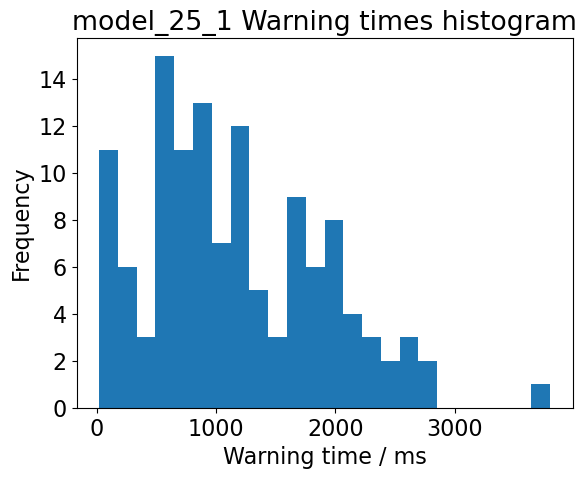

In [297]:
wanted_index = 10
# remove nans from warning_times
warning_times_nonan = [wt for wt in warning_times_list[wanted_index] if wt is not None]
plt.hist(warning_times_nonan, bins=24)
print(np.mean(warning_times_nonan))
# print median
print(np.median(warning_times_nonan))
plt.xlabel('Warning time / ms')
plt.ylabel('Frequency')
plt.title(f'{output_filename_base} Warning times histogram')
plt.show()

with open('figure_data/model_25_warning_times_list.pkl', 'wb') as f:
    pickle.dump(warning_times_list, f)

0.8172319183342921


/home/hf8585/.conda/envs/torch/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/hf8585/.conda/envs/torch/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


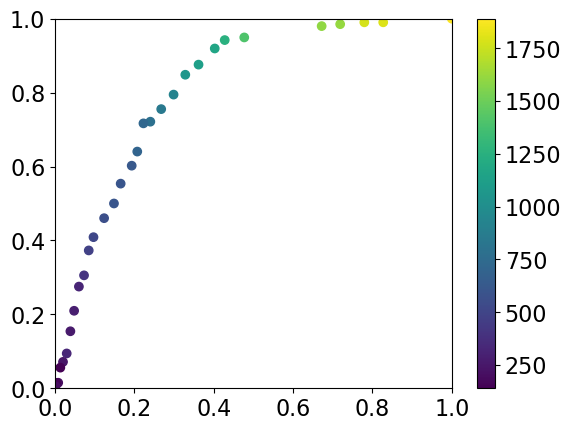

In [268]:
new_tprs = []
new_fprs = []
warning_times = []
for i in range(100):
    warning_times_nonan = [wt for wt in warning_times_list[i] if wt is not None]
    jumps = jumps_list[i]
    new_classification_list = classification_list[i].copy()
    for j in range(len(classification_list[i])):
        if classification_list[i][j] == -1 and jumps[j] != 0:
            new_classification_list[j] = -2
        elif classification_list[i][j] == 0 and jumps[j] != 0:
            new_classification_list[j] = -1

    # tps = np.sum(np.array(classification_list[i])==1) - np.sum(np.array(warning_times_nonan)<100)
    # fns = np.sum(np.array(classification_list[i])==0)
    # tns = np.sum(np.array(classification_list[i])==-1)
    # fps = np.sum(np.array(classification_list[i])==-2) + np.sum(np.array(jumps_list[i])!=0)
    tps = np.sum(np.array(new_classification_list)==1) - np.sum(np.array(warning_times_nonan)<100)
    fns = np.sum(np.array(new_classification_list)==0)
    tns = np.sum(np.array(new_classification_list)==-1)
    fps = np.sum(np.array(new_classification_list)==-2)

    tpr = tps/(tps+fns)
    fpr = fps/(fps+tns)
    new_tprs.append(tpr)
    new_fprs.append(fpr)
    warning_times.append(np.median(warning_times_nonan))
# plot new_fprs vs new_tprs but where the curve is coloured by the median warning time, with colours from blue to red, and with a colorbar on the right

plt.scatter(new_fprs[:], new_tprs[:], c=warning_times[:])
plt.colorbar()
# plt.plot(new_fprs, new_tprs)
# plt.plot(fprs, 1-fnrs)
plt.ylim(0, 1)
plt.xlim(0, 1)
#print(metrics_helpers.get_auc(fprs, 1-fnrs))
print(metrics_helpers.get_auc(new_fprs, new_tprs))

In [269]:
main_model_roc_data = {'fprs': np.array(new_fprs), 'tprs': np.array(new_tprs), 'median_warning_times': np.array(warning_times)}
with open('figure_data/model_23_roc_data.pkl', 'wb') as f:
    pickle.dump(main_model_roc_data, f)
extra_main_model_roc_data = {'fprs': np.array(fprs), 'tprs': np.array(tprs), 'warning_times': np.array(warning_times_list), 'jumps': np.array(jumps_list), 'classification': np.array(classification_list)}
with open('figure_data/extra_model_23_roc_data.pkl', 'wb') as f:
    pickle.dump(extra_main_model_roc_data, f)

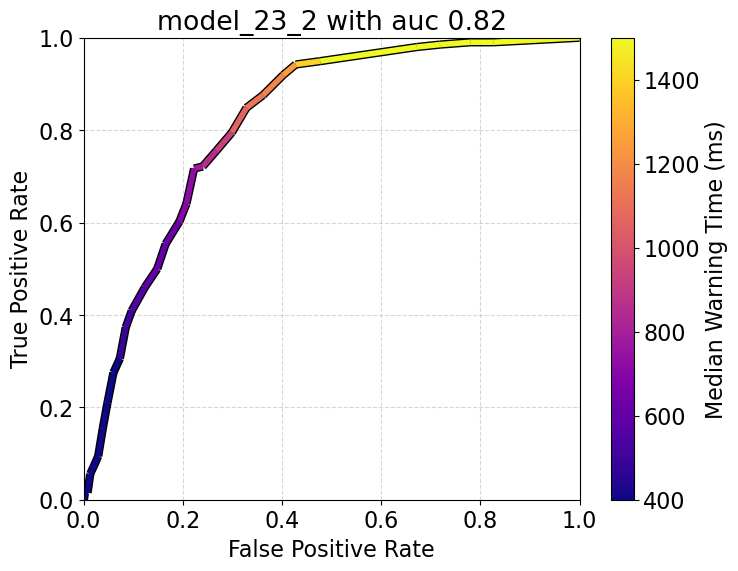

In [270]:
plotting_helpers.plot_fpr_tpr_warning_time(np.array(new_fprs), np.array(new_tprs), np.array(warning_times), f"{output_filename_base} with auc {metrics_helpers.get_auc(new_fprs, new_tprs):.2g}")

In [86]:
def find_peaks_in_data(data):
    peaks = []
    for i in range(1, len(data) - 1):
        if data[i-1] < data[i] > data[i+1]:
            peaks.append(i)
    return peaks

def fnr_fpr_calculator(model, normed_x, normed_t, normed_e, prediction_times, threshold=0.7):
    out_survival = model.predict_survival(normed_x, prediction_times)
    fnrs = []
    fprs = []
    shot_indices = find_peaks_in_data(normed_t)
    for i, time in enumerate(prediction_times):
        tm_prediction_per_shot = []
        # 1 means correct TM prediction (TP), 0 means unpredicted TM (FN), -1 means no TM in shot and no TM predicted (TN), -2 means no TM in shot and yes TM predicted (FP)
        # a TM is predicted when the survival prediction is 0 at any point in the shot. Check if better results when TM is consecutive 0s
        survival_prediction = out_survival[:,i]
        survival_prediction = (survival_prediction > threshold).astype(int)
        for j, shot_index in enumerate(shot_indices[:-1]):
            tm = (0 in survival_prediction[shot_indices[j]:shot_indices[j+1]])
            if normed_e[shot_index] == 1 and tm:
                tm_prediction_per_shot.append(1)
            elif normed_e[shot_index] == 1 and not tm:
                tm_prediction_per_shot.append(0)
            elif normed_e[shot_index] == 0 and not tm:
                tm_prediction_per_shot.append(-1)
            elif normed_e[shot_index] == 0 and tm:
                tm_prediction_per_shot.append(-2)
        fnr = tm_prediction_per_shot.count(0) / (tm_prediction_per_shot.count(1) + tm_prediction_per_shot.count(0))
        fpr = tm_prediction_per_shot.count(-2) / (tm_prediction_per_shot.count(-1) + tm_prediction_per_shot.count(-2))
        #print(f'fnr: {fnr} from {tm_prediction_per_shot.count(1) + tm_prediction_per_shot.count(0)} shots, fpr: {fpr} from {tm_prediction_per_shot.count(-1) + tm_prediction_per_shot.count(-2)} shots')
        fnrs.append(fnr)
        fprs.append(fpr)
    auc_fnr = np.trapz(fnrs, prediction_times)
    auc_fpr = np.trapz(fprs, prediction_times)
    return auc_fpr, auc_fnr, fprs, fnrs, prediction_times

/home/hf8585/TMPredictor/survival_tm/auton-survival/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values
/home/hf8585/TMPredictor/survival_tm/auton-survival/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values
/home/hf8585/TMPredictor/survival_tm/auton-survival/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[

Text(0.5, 1.0, 'model2 ROC with auc = 0.9122835545398611')

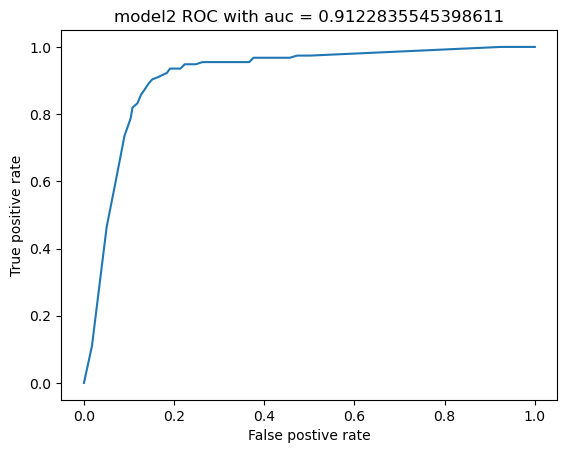

In [87]:
thresholds = np.linspace(0, 1, 100)
fprs_list_rt = []
fnrs_list_rt = []


for threshold in thresholds:
    x_train_df = pd.DataFrame(x)
    t_valid = np.array(t)
    e_valid = np.array(e)
    auc_fpr, auc_fnr, fprs, fnrs, prediction_times = fnr_fpr_calculator(loaded_models[0][0], x_train_df[9*len(x_train_df)//10:], t_valid[9*len(x_train_df)//10:], e_valid[9*len(x_train_df)//10:], [1000], threshold=threshold)
    fprs_list_rt.append(fprs[0])
    fnrs_list_rt.append(fnrs[0])
auc = 1-np.trapz(fnrs_list_rt, fprs_list_rt)
plt.plot(np.array(fprs_list_rt), 1-np.array(fnrs_list_rt))
plt.ylabel('True positive rate')
plt.xlabel('False postive rate')
plt.title(f'{output_filename_base} ROC with auc = {auc}')

In [93]:
print(np.trapz(1-np.array(fnrs_list_rt), np.array(fprs_list_rt)))

0.9122835545398611
